# Notebook de comprobación de datos entre datasets v1 y v2

In [1]:
import sys
sys.path.append("../../") # go to src folder
# from customFunctions import *

In [2]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tpot import TPOTRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
from metrics import mean_absolute_percentage_error
from plotnine import *
import plotnine as pltn
from joblib import dump, load

import tensorflow as tf

from data.datasets import load_dataset, load_dataset_count
from modeling.eval import eval_model
from modeling.training import create_training_folder
from random import randrange
import matplotlib.pyplot as plt

sys.path.append("../..") # go to parent dir
# from customFunctions import *

# %matplotlib notebook
%matplotlib inline

BASE_FOLDER = "../../../resources/dataset"

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Using TensorFlow backend.


In [3]:
# leemos lo dos datasets
df1 = pd.read_parquet(os.path.join(BASE_FOLDER, '2015_2019_daily_v1.pck'))
df2 = pd.read_parquet(os.path.join(BASE_FOLDER, '2015_2019_daily_v2.pck'))

# find missing data
print(df1[["idest", "date"]].dtypes)
print(df2[["idest", "date"]].dtypes)

df1["idest"] = df1["idest"].astype(str).str.pad(5, "left", "0")



idest             int32
date     datetime64[ns]
dtype: object
idest            object
date     datetime64[ns]
dtype: object


In [4]:
# comparar tamaño de datasets

print("date range v1: {} - {}".format(df1.date.min(), df1.date.max()))
print("date range v2: {} - {}".format(df2.date.min(), df2.date.max()))

# filtrar dataset v2 para tener las mismas fechas
df2 = df2[df2.date <= df1.date.max()]
df2 = df2[df2.date >= df1.date.min()]

print(df1.shape)
print(df2.shape)

print("Num estaciones v1: {}".format(len(df1.idest.unique())))
print("Num estaciones v2: {}".format(len(df1.idest.unique())))

df1.set_index(["idest", "date"], inplace=True)
df2.set_index(["idest", "date"], inplace=True)



date range v1: 2015-01-02 00:00:00 - 2019-11-26 00:00:00
date range v2: 2015-01-01 00:00:00 - 2019-12-31 00:00:00
(89752, 59)
(89850, 62)
Num estaciones v1: 51
Num estaciones v2: 51


In [5]:
print("Valores duplicados en df1: {}".format(df1[df1.index.duplicated()].shape))
print("Valores duplicados en df2: {}".format(df2[df2.index.duplicated()].shape))

# df = df.reset_index().drop_duplicates(subset =["idest","date"], keep="first")                                                                                                

# df.sort_values(["idest","date"]).drop_duplicates(subset =["idest","date"], keep="first").shape   

Valores duplicados en df1: (0, 57)
Valores duplicados en df2: (0, 60)


Se han encontrado 1550 duplicados en el segundo dataframe, inspecionándolo, enero 2017 tiene datos duplicados para todas las estaciones. Los datos climáticos vienen ya con duplicados (/media/data/climate/inforiego_2014-2020_daily.pkt)

In [6]:

# df2[~df2[["date","idest"]].isin(df1[["date","idest"]])].shape
df_res = df2.join(df1, how="left", rsuffix="_r")
a = df_res[df_res.detected_r.isnull()].shape[0]
print("Num datos que están en v2 y no en v1: {}".format(a))
df_res = df1.join(df2, how="left", rsuffix="_r")
b = df_res[df_res.detected_r.isnull()].shape[0]
print("Num datos que están en v1 y no en v2: {}".format(b))

print(b-a)


Num datos que están en v2 y no en v1: 152
Num datos que están en v1 y no en v2: 54
-98


In [11]:
# histogramas por fechas

# plt.figure(figsize=(60,40), dpi= 100, facecolor='w', edgecolor='k')
pltn.options.figure_size = (30, 10)
dff1 = df1[df1.n_um_10d > 0].reset_index()
dff2 = df2[df2.n_um_10d > 0].reset_index()
print("df1 shape: {}".format(dff1.shape))
print("df2 shape: {}".format(dff2.shape))

(ggplot(dff1)
 + aes(x='month')
 + geom_bar(colour="blue", fill=None)
 + geom_bar(data=dff2,colour='red', fill=None)
 +facet_grid(".~ year")
)



df1 shape: (15303, 59)
df2 shape: (15349, 62)


<ggplot: (-9223363278466623996)>

In [14]:
c1 = df1.columns
c2 = df2.columns

print("c1 {}, c2 {}".format(len(c1), len(c2)))
common_cols = [c for c in c2 if c in c1 and c not in ["altitud","altitud_est"]] + ["idest","date"]

common_cols


c1 57, c2 60


['temp_min',
 'temp_max',
 'temp_mean',
 'temp_median',
 'temp_std',
 'prec_min',
 'prec_max',
 'prec_mean',
 'prec_median',
 'prec_std',
 'hum_min',
 'hum_max',
 'hum_mean',
 'hum_median',
 'hum_std',
 'prec_30d',
 'prec_60d',
 'prec_expected_30d',
 'prec_expected_60d',
 'roya_event_10d',
 'roya_event_skip_10d',
 'prec_exp_perc_30d',
 'prec_exp_perc_60d',
 'prec_exp_sgm_30d',
 'year',
 'month',
 'month_sin',
 'month_cos',
 'week',
 'week_sin',
 'week_cos',
 'dyear',
 'dyear_sin',
 'dyear_cos',
 'roya_perc_event_skip_10d',
 'detected_10d',
 'n_um_10d',
 'altitud',
 'altitud_est',
 'n_um',
 'detected',
 'idest',
 'date']

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


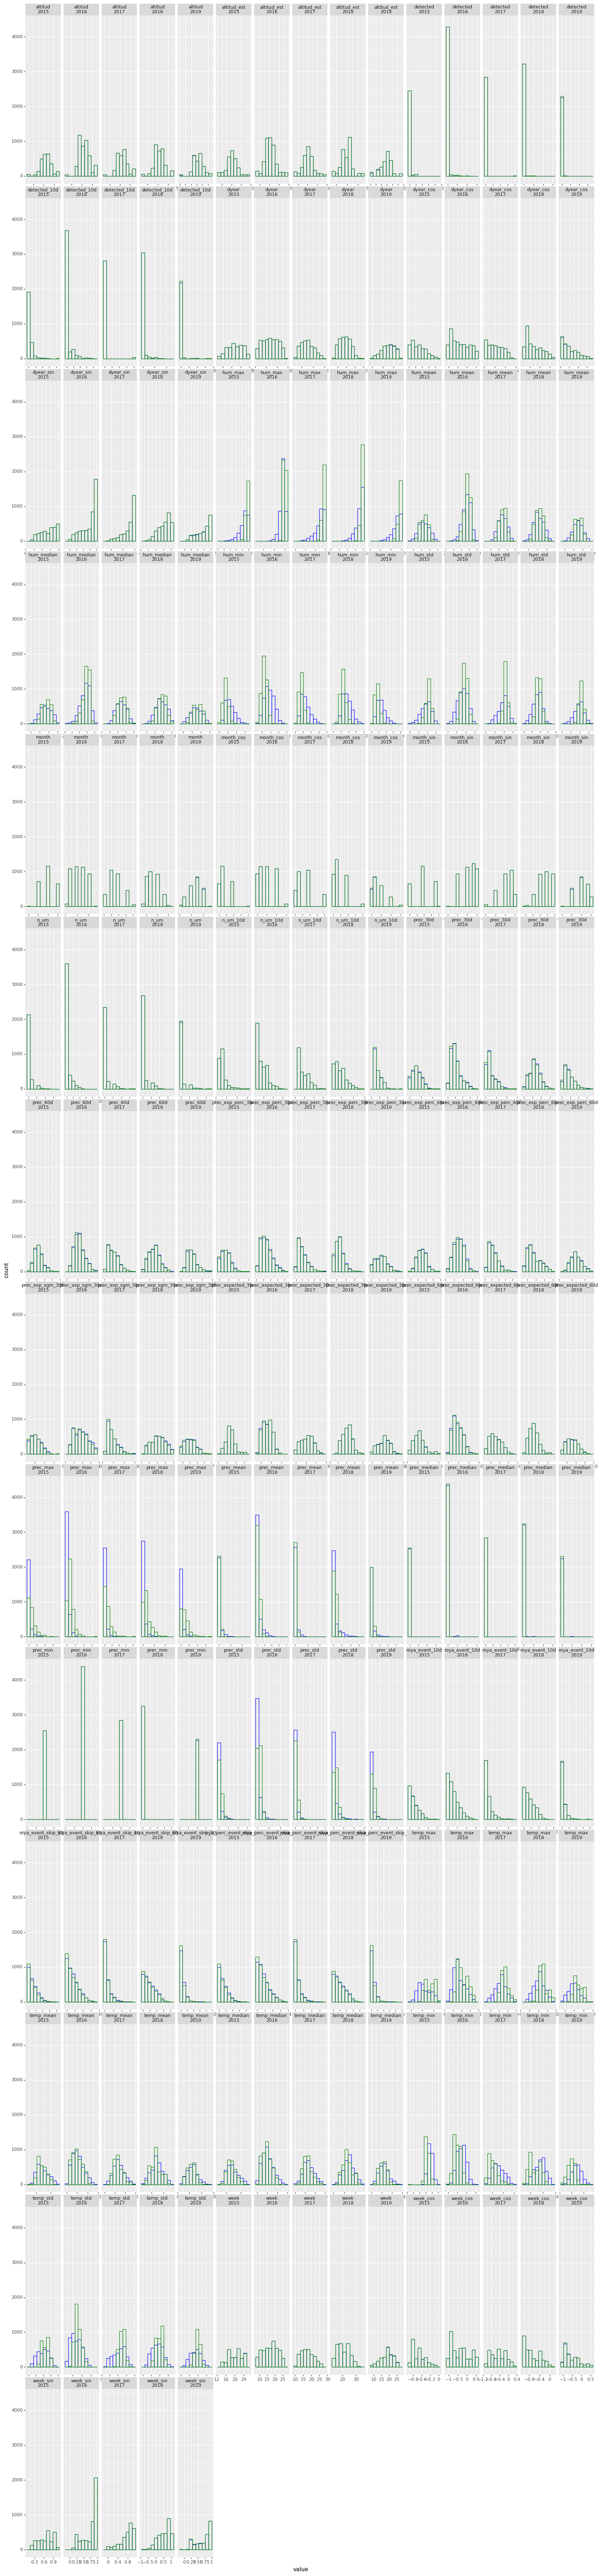

<ggplot: (-9223363278490801969)>

In [17]:
pltn.options.figure_size = (20, 90)

# comprobar que las distribuciones de los datos son las mismas
(ggplot(dff1[common_cols].melt(id_vars = ["idest","date","year"]))
 + aes("value")
 + geom_histogram(bins = 10, fill=None, colour="blue")
 + geom_histogram(data = dff2[common_cols].melt(id_vars = ["idest","date","year"]), bins = 10, fill=None, colour="green")
 + facet_wrap("~ variable + year", scales = 'free_x')
#  + facet_grid("variable ~ year")
)

# ggplot(gather(df1), aes(value)) + 
#     geom_histogram(bins = 10) + 
#     facet_wrap(~key, scales = 'free_x')
    